# import packages

In [48]:
import pyspark
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import chart_studio.plotly as py

import plotly.express as px 
from jupyter_dash import JupyterDash 
import dash_core_components as dcc 
import dash_html_components as html 
from dash.dependencies import Input, Output
app = JupyterDash(__name__) 

In [5]:
# ! pip install chart_studio

# Config spark envir

In [6]:
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages "org.apache.hadoop:hadoop-aws:3.3.1" pyspark-shell'

In [7]:
sc = pyspark.SparkContext.getOrCreate()

In [8]:
hadoopConf = sc._jsc.hadoopConfiguration()
sc._jsc.hadoopConfiguration().set("fs.s3.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")
sc._jsc.hadoopConfiguration().set('fs.s3a.access.key', os.environ['AWS_ACCESS_KEY_ID'])
sc._jsc.hadoopConfiguration().set('fs.s3a.secret.key', os.environ['AWS_SECRET_ACCESS_KEY'])

# read in data

In [10]:
# read in the whole data
rdd = sc.textFile("s3://usf-msds694-openpayments/BigSets/OP_DTL_GNRL_PGYR2019_P06302021.csv")

In [11]:
# extract the header
header_str = rdd.first()
header = header_str.split(",")

In [12]:
# create a header dict that can help us find the corresponding index
header_dict = dict()
for i, h in enumerate(header):
    header_dict[h] = i

In [13]:
# sample out tiny data for exploration
tiny_data = sc.parallelize(rdd.take(501)).filter(lambda x: x!=header_str)

In [14]:
# change the tiny data to list rdd
import re
COMMA_MATCHER = re.compile(r",(?=(?:[^\"]*[\"][^\"]*[\"])*[^\"]*$)")
list_rdd = tiny_data.map(lambda x: COMMA_MATCHER.split(x))

In [15]:
# store list_rdd in memory
list_rdd.cache()

PythonRDD[5] at RDD at PythonRDD.scala:53

In [16]:
# convert tiny data to pandas for EDA
df = pd.DataFrame(list_rdd.collect(), columns=header)
df.head()

,Change_Type,Covered_Recipient_Type,Teaching_Hospital_CCN,Teaching_Hospital_ID,Teaching_Hospital_Name,Physician_Profile_ID,Physician_First_Name,Physician_Middle_Name,Physician_Last_Name,Physician_Name_Suffix,...,Product_Category_or_Therapeutic_Area_4,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_4,Associated_Drug_or_Biological_NDC_4,Covered_or_Noncovered_Indicator_5,Indicate_Drug_or_Biological_or_Device_or_Medical_Supply_5,Product_Category_or_Therapeutic_Area_5,Name_of_Drug_or_Biological_or_Device_or_Medical_Supply_5,Associated_Drug_or_Biological_NDC_5,Program_Year,Payment_Publication_Date
0,"""UNCHANGED""","""Covered Recipient Physician""",,,,"""24604""","""JAMES""","""E""","""BROWN""","""JR.""",...,,,,,,,,,"""2019""","""06/30/2021"""
1,"""UNCHANGED""","""Covered Recipient Physician""",,,,"""145724""","""EARLANDO""","""O""","""THOMAS""",,...,,,,,,,,,"""2019""","""06/30/2021"""
2,"""UNCHANGED""","""Covered Recipient Physician""",,,,"""216332""","""KATHERINE""","""S""","""LAMMERS""",,...,,,,,,,,,"""2019""","""06/30/2021"""
3,"""UNCHANGED""","""Covered Recipient Physician""",,,,"""676113""","""ROBIN""","""B""","""BONE""",,...,,,,,,,,,"""2019""","""06/30/2021"""
4,"""UNCHANGED""","""Covered Recipient Physician""",,,,"""424082""","""ARCHANA""","""R""","""PAINE""",,...,,,,,,,,,"""2019""","""06/30/2021"""


# exploration on tiny dataset

In [43]:
# let's check unique values in the data
# for h in header:
#     print(h + '---' + str(df[h].unique()))

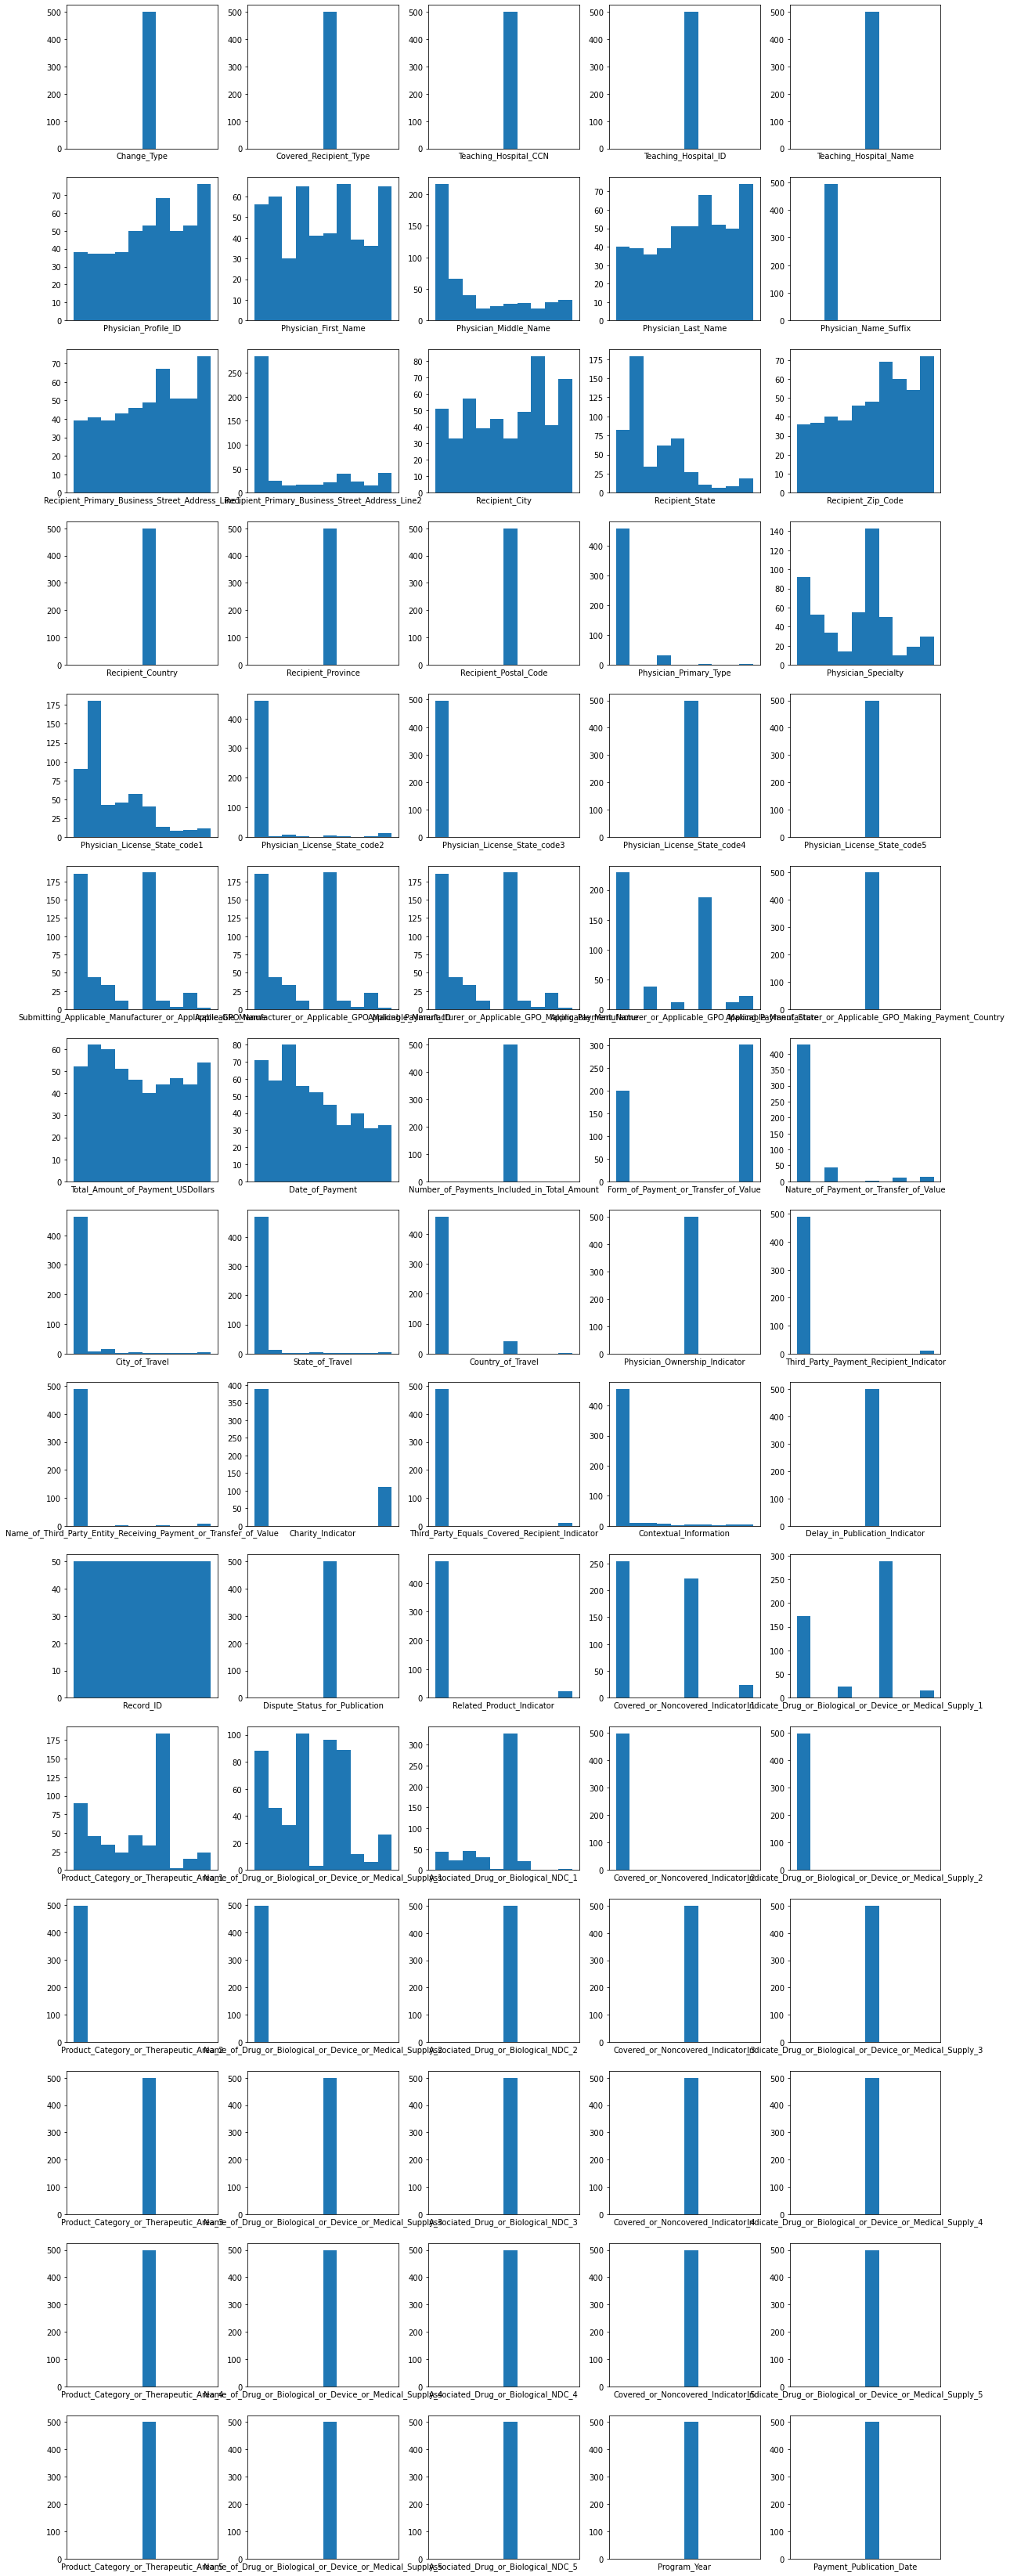

In [46]:
# let's see the distribution of values
figure, axis = plt.subplots(15, 5, figsize =(20, 60))
ax = axis.flatten()
for i in range(75):
    ax[i].hist(df[header[i]])
    ax[i].set_xlabel(header[i])
    ax[i].set_xticks([])
plt.show()

# Basic visualization

In [19]:
import plotly.express as px
import plotly.graph_objects as go

### recipient state against total amount of payment

In [47]:
pd.set_option("display.max_columns", None)
pd.DataFrame(list_rdd.take(5))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74
0,"""UNCHANGED""","""Covered Recipient Physician""",,,,"""24604""","""JAMES""","""E""","""BROWN""","""JR.""","""729 1/2 N MAIN ST""",,"""NORTH SYRACUSE""","""NY""","""13212-1651""","""United States""",,,"""Medical Doctor""","""Allopathic & Osteopathic Physicians|Obstetric...","""NY""",,,,,"""Mission Pharmacal Company""","""100000000186""","""Mission Pharmacal Company""","""TX""","""United States""",12.30,"""11/20/2019""","""1""","""In-kind items and services""","""Food and Beverage""",,,,"""No""","""No Third Party Payment""",,"""No""",,,"""No""","""625331753""","""No""","""Yes""","""Covered""","""Drug""","""Prenatal Vitamin & Mineral""","""CitraNatal""","""0178-0796-30""",,,,,,,,,,,,,,,,,,,,,"""2019""","""06/30/2021"""
1,"""UNCHANGED""","""Covered Recipient Physician""",,,,"""145724""","""EARLANDO""","""O""","""THOMAS""",,"""2337 RIDGEWAY AVE""",,"""ROCHESTER""","""NY""","""14626""","""United States""",,,"""Medical Doctor""","""Allopathic & Osteopathic Physicians|Obstetric...","""NY""",,,,,"""Mission Pharmacal Company""","""100000000186""","""Mission Pharmacal Company""","""TX""","""United States""",15.80,"""11/20/2019""","""1""","""In-kind items and services""","""Food and Beverage""",,,,"""No""","""No Third Party Payment""",,"""No""",,,"""No""","""625331755""","""No""","""Yes""","""Covered""","""Drug""","""Prenatal Vitamin & Mineral""","""CitraNatal""","""0178-0796-30""",,,,,,,,,,,,,,,,,,,,,"""2019""","""06/30/2021"""
2,"""UNCHANGED""","""Covered Recipient Physician""",,,,"""216332""","""KATHERINE""","""S""","""LAMMERS""",,"""2337 RIDGEWAY AVE""",,"""ROCHESTER""","""NY""","""14626""","""United States""",,,"""Medical Doctor""","""Allopathic & Osteopathic Physicians|Obstetric...","""NY""",,,,,"""Mission Pharmacal Company""","""100000000186""","""Mission Pharmacal Company""","""TX""","""United States""",15.80,"""11/20/2019""","""1""","""In-kind items and services""","""Food and Beverage""",,,,"""No""","""No Third Party Payment""",,"""No""",,,"""No""","""625331757""","""No""","""Yes""","""Covered""","""Drug""","""Prenatal Vitamin & Mineral""","""CitraNatal""","""0178-0796-30""",,,,,,,,,,,,,,,,,,,,,"""2019""","""06/30/2021"""
3,"""UNCHANGED""","""Covered Recipient Physician""",,,,"""676113""","""ROBIN""","""B""","""BONE""",,"""2700 NAPOLEON AVE""","""SUITE 560""","""NEW ORLEANS""","""LA""","""70115-6914""","""United States""",,,"""Medical Doctor""","""Allopathic & Osteopathic Physicians|Obstetric...","""LA""",,,,,"""Mission Pharmacal Company""","""100000000186""","""Mission Pharmacal Company""","""TX""","""United States""",17.28,"""06/14/2019""","""1""","""In-kind items and services""","""Food and Beverage""",,,,"""No""","""No Third Party Payment""",,"""No""",,,"""No""","""625331759""","""No""","""Yes""","""Covered""","""Drug""","""Prenatal Vitamin & Mineral""","""CitraNatal""","""0178-0796-30""",,,,,,,,,,,,,,,,,,,,,"""2019""","""06/30/2021"""
4,"""UNCHANGED""","""Covered Recipient Physician""",,,,"""424082""","""ARCHANA""","""R""","""PAINE""",,"""2700 NAPOLEON AVE""","""SUITE 560""","""NEW ORLEANS""","""LA""","""70115-6914""","""United States""",,,"""Medical Doctor""","""Allopathic & Osteopathic Physicians|Obstetric...","""LA""",,,,,"""Mission Pharmacal Company""","""100000000186""","""Mission Pharmacal Company""","""TX""","""United States""",17.28,"""06/14/2019""","""1""","""In-kind items and services""","""Food and Beverage""",,,,"""No""","""No Third Party Payment""",,"""No""",,,"""No""","""625331761""","""No""","""Yes""","""Covered""","""Drug""","""Prenatal Vitamin & Mineral""","""CitraNatal""","""0178-0796-30""",,,,,,,,,,,,,,,,,,,,,"""2019""","""06/30/2021"""


In [21]:
# I am interested in recipient state and total amount of payment, let's take a look
payment_per_state = list_rdd.map(lambda x: (x[13].replace('"',""), float(x[30].replace('"',""))))\
                            .groupByKey().mapValues(lambda x: sum(x))\
                            .sortBy(lambda x : x[1], ascending = False)

In [22]:
# convert to dataframe
payment_per_state_df = pd.DataFrame(payment_per_state.collect(), columns=['state', 'amount'])
payment_per_state_df.head()

,state,amount
0,TX,37552.57
1,FL,27626.35
2,CA,16918.13
3,KY,13540.86
4,OH,6220.89


In [59]:
# plot
fig1 = px.histogram(payment_per_state_df, x='state', y='amount')

In [58]:
# Since it is state data, a map plot might be better
fig2 = go.Figure(data=go.Choropleth(
    locations=payment_per_state_df['state'], # Spatial coordinates
    z = payment_per_state_df['amount'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    colorbar_title = "dollar",
))

null = fig2.update_layout(
    title_text = 'Payment Received Per State',
    geo_scope='usa', # limite map scope to USA
)

### Physician against amount

In [25]:
# I am interested in what type of Physician gets most
payment_per_physician_type = list_rdd.map(lambda x: (x[18].replace('"',""), float(x[30].replace('"',""))))\
                            .groupByKey().mapValues(lambda x: sum(x))\
                            .sortBy(lambda x : x[1], ascending = False)

In [26]:
# convert to dataframe
payment_per_physician_type_df = pd.DataFrame(payment_per_physician_type.collect(), columns=['physician_type', 'amount'])
payment_per_physician_type_df.head()

,physician_type,amount
0,Medical Doctor,111957.05
1,Doctor of Optometry,13513.50
2,Doctor of Osteopathy,1173.32
3,Doctor of Podiatric Medicine,126.14


In [56]:
# plot
fig3 = px.histogram(payment_per_physician_type_df, x='physician_type', y='amount')

### specialities against amount

In [28]:
# I am interested in what type of specialities gets most
payment_per_speciality_type = list_rdd.map(lambda x: (x[19].replace('"',""), float(x[30].replace('"',""))))\
                            .groupByKey().mapValues(lambda x: sum(x))\
                            .sortBy(lambda x : x[1], ascending = False)

In [29]:
# convert to dataframe
payment_per_speciality_type_df = pd.DataFrame(payment_per_speciality_type.collect(), columns=['Physician_Specialty', 'amount'])
payment_per_speciality_type_df.head()

,Physician_Specialty,amount
0,Allopathic & Osteopathic Physicians|Ophthalmology,32400.00
1,Allopathic & Osteopathic Physicians|Surgery|Pl...,15639.43
2,Allopathic & Osteopathic Physicians|Thoracic S...,14779.09
3,Eye and Vision Services Providers|Optometrist,13513.50
4,Allopathic & Osteopathic Physicians|Orthopaedi...,11723.10


In [55]:
# plot
fig4 = px.histogram(payment_per_speciality_type_df.iloc[1:,], x='Physician_Specialty', y='amount')

### drug cost per state against payment received per state

In [31]:
# read in the whole data
rdd2 = sc.textFile("s3://usf-msds694-openpayments/BigSets/MUP_DPR_RY21_P04_V10_DY19_NPIBN_1.csv")
# sample out tiny data
tiny_data_2 = rdd2.sample(False, 0.00002)
tiny_data_2.cache()

PythonRDD[42] at RDD at PythonRDD.scala:53

In [32]:
header2 = rdd2.first().split(",")
header2
header2_dict = dict()
for i, h in enumerate(header2):
    header2_dict[h] = i

In [33]:
# change the tiny data 2 to list rdd
list_rdd_2 = tiny_data_2.map(lambda x: COMMA_MATCHER.split(x))

In [34]:
# I am guessing the state that received more payment will have a larger drug cost
cost_per_state = list_rdd_2.map(lambda x: (x[4], float(x[13].replace('','0'))))\
                            .groupByKey().mapValues(lambda x: sum(x))\
                            .sortBy(lambda x : x[1], ascending = False)

In [35]:
payment_cost_per_state = payment_per_state.leftOuterJoin(cost_per_state).map(lambda x: [x[0], x[1][0], x[1][1]])

In [36]:
# convert to dataframe
payment_cost_per_state_df = pd.DataFrame(payment_cost_per_state.collect(), columns=['state', 'payment_amount','drug_cost'])
payment_cost_per_state_df.head()

,state,payment_amount,drug_cost
0,WV,12.56,1.131311e+07
1,PA,439.25,1.115230e+11
2,UT,1124.39,1.107100e+06
3,GA,4404.09,2.175646e+09
4,MD,137.23,1.101416e+09


In [54]:
# plot
fig5 = px.scatter(payment_cost_per_state_df, x="payment_amount", y="drug_cost")

### nature of payment percentage

In [38]:
# extract
nature_of_payment_count = list_rdd.map(lambda x: x[34].replace('"','')).countByValue()

In [39]:
nature_of_payment_count_df = pd.DataFrame.from_dict(nature_of_payment_count, orient='index', columns = ['counts'])
nature_of_payment_count_df.reset_index(inplace=True)
nature_of_payment_count_df

,index,counts
0,Food and Beverage,428
1,Travel and Lodging,43
2,Entertainment,1
3,Consulting Fee,13
4,Honoraria,15


In [53]:
fig6 = px.pie(nature_of_payment_count_df, values='counts', names='index', title='nature of payment percentage')

# make html file with all plots

In [49]:
# with open('graphs.html', 'w') as f:
#     f.write(fig1.to_html(full_html=False, include_plotlyjs='cdn'))
#     f.write(fig2.to_html(full_html=False, include_plotlyjs='cdn'))
#     f.write(fig3.to_html(full_html=False, include_plotlyjs='cdn'))
#     f.write(fig4.to_html(full_html=False, include_plotlyjs='cdn'))
#     f.write(fig5.to_html(full_html=False, include_plotlyjs='cdn'))
#     f.write(fig6.to_html(full_html=False, include_plotlyjs='cdn'))

In [50]:
app.layout = html.Div([
    html.H1("JupyterDash Demo"),
    dcc.Graph(id='graph1', figure=fig1),
    dcc.Graph(id='graph2', figure=fig2),
    dcc.Graph(id='graph3', figure=fig3),
    dcc.Graph(id='graph4', figure=fig4),
    dcc.Graph(id='graph5', figure=fig5),
    dcc.Graph(id='graph6', figure=fig6),
    html.Div([
        html.P('Dash converts Python classes into HTML'),
        html.P("This conversion happens behind the scenes by Dash's JavaScript front-end")
    ]),
    html.Label([
        "colorscale",
        dcc.Dropdown(
            id='colorscale-dropdown', clearable=False,
            value='plasma', options=[
                {'label': c, 'value': c}
                for c in px.colors.named_colorscales()
            ])
    ]),
])

In [52]:
app.run_server(mode='jupyterlab', debug=True, port=8051)

In [42]:
# Used to push on the github pages
fig1.write_html("../docs/_includes/fig3.html")
fig2.write_html("../docs/_includes/fig4.html")
fig3.write_html("../docs/_includes/fig5.html")
fig4.write_html("../docs/_includes/fig6.html")
fig5.write_html("../docs/_includes/fig7.html")
fig6.write_html("../docs/_includes/fig8.html")

In [ ]:
# stop instance
sc.stop()